In [ ]:
# Les Pipelines avancées permettent de traiter des bdd Hétérogènes, càd qui contiennent différents type de variables 


In [36]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, Binarizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer

import seaborn as sns

In [2]:
titanic = sns.load_dataset('titanic')
titanic

# On a donc différents type de variables

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
# On va créer dans notre Pipeline un mécanisme qui permet de trier les colonnes qui va donner certaines colonnes à certain transformer
# et d'autre colonnes à d'autres transformers, selon leur type et le transformer qui lui est donc associé.

## Pour faire ça, on utilise la fonction "make_column_transformer"

# I -  make_column_transformer

In [8]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline


y = titanic['survived']
X = titanic.drop('survived', axis=1)

In [7]:
# On écrit sous forme de tuple l'opération de tranformation qui doit être effectué, suivi de la liste de toutes les colonnes qui 
# doivent subir cette transformation

transformer = make_column_transformer((StandardScaler(),
                                      ['age', 'fare']))

In [9]:
# Ensuite, comme tout transformer, on peut l'entraîner avec une méthode 'fit'

## On lui soumet toutes nos variables, ie le tableau X, mais il ne va traiter que les colonnes définit prédcedemment

transformer.fit_transform(X)

array([[-0.53037664, -0.50244517],
       [ 0.57183099,  0.78684529],
       [-0.25482473, -0.48885426],
       ...,
       [        nan, -0.17626324],
       [-0.25482473, -0.04438104],
       [ 0.15850313, -0.49237783]])

In [16]:
# Au lieu de simplement l'écrir en tant que tel, on va intégrer ce tranformer dans notre pipeline de base, qui devient alors un 
# Pipeline_Composite

## Voila notre Pipeline orignial

model = make_pipeline(StandardScaler(), SGDClassifier())
model

### Ainsi, à la place d'écrire StandardScaler() ne tant que tel, on va utiliser StandarScaler() à travers le 'transformer' qui est 
### un 'column_tranformer'

#### On écrit alors :

model = make_pipeline(transformer, SGDClassifier())
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'fare'])])),
                ('sgdclassifier', SGDClassifier())])

In [45]:
# Afin de créer des Pipeline un peu plus riches et un peu plus complex 

## On va faire le trie entre nos variable catégorielles et numériques 

numerical_features = ['pclass', 'age', 'fare']
categorical_features = ['sex', 'deck', 'alone']


In [20]:
# A partir de ces deux listes de variables on va pouvoir utiliser un "make_column_transformer" pour appliquer une première série 
# de tranformation sur 'numerical_feature', puis une autre série sur 'categorical_feature'

## Il nous faut d'abord définir nos Categorical & Numerical Pipeline

numerical_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())


In [21]:
# En intégrant ces Pipeline on créer alors un transformer de type 'preprocessor'

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                       (categorical_pipeline, categorical_features))


In [22]:
# On l'utilise alors pour créer notre Pipeline Finale 

model = make_pipeline(preprocessor, SGDClassifier())


In [47]:
# On finit, comme toujours, par 'fit' notre transformer+estimateur ~ Pipeline ~ notre model
# Après avoir créer nos Test et Train Set bien évidemment

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7802690582959642

# Recap Method 

## 1) Faire le tri entre nos variables numériques et catégorielles 

## 2) Définir pour chaque liste (ie une pour numérique, une pour catégorielle), une Pipeline

## 3) Pour finir, on injecte ces Pipelines dans la fonctions make_column_trasnformer

## 4) Cela nous retourne alors un 'Preprocessor'

## 5) On conclue en utlisant ce 'preprocessor' dans notre Pipeline finale, celle qui définit notre modèle de Machine Learning

# II - Make_column_selectore

In [30]:
from sklearn.compose import make_column_selector

# Cette fonction permet de selectionner nos variable non pas de façon explicite


In [31]:
# On reprend ainsi juste cette étape avec la fonction, à qui on indique simplement le type de variable que l'on souhaite sélectionner

## On peut même choisir un type selon un pattern que l'on a dans le nom de la variable
## Par exemple, sélectionner toutes les variables dont le nom commence par 'abc_st'

### Les variables de type numériques sont les 'np.number'

numerical_features = make_column_selector(dtype_include=np.number)

### Et pour toutes les catégories, on exclu les nombres

categorical_features = make_column_selector(dtype_exclude=np.number)


# III- Créer des Piplelines parallèles, "make_union'

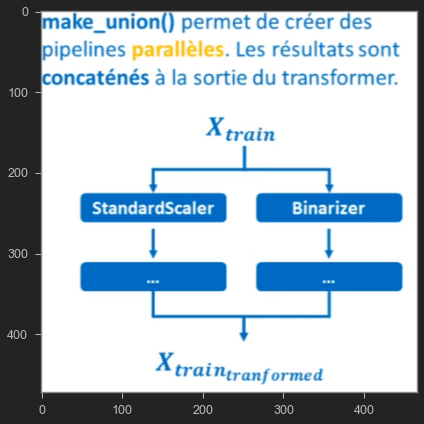

In [48]:
from sklearn.pipeline import make_union

# Nous avons jusque ici créer des Pipelines en mettant bout à bout plusieurs 'trasnformers'
# On créait ainsi une 'série de Transformers'

## Mais on peut également créer des Pipeline qui mettent en parallèles plusieurs tranformeurs et qui rejoins leurs différents 
## résultats dans un seul et même tableau

image = plt.imread("Make_Union.png")
plt.imshow(image)

In [58]:
numerical_features = X[['age', 'fare']]
numerical_features=numerical_features.dropna()

In [56]:
# Tout ce qu'on a à faire est d'entrér les transformers que l'on veut avoir en parallèle

## Par exemple :
    # D'un cotés on veut 'Standardiser' ces deux variables
    # Et également les 'Discrétiser'

pipeline = make_union(StandardScaler(), Binarizer())
pipeline



FeatureUnion(transformer_list=[('standardscaler', StandardScaler()),
                               ('binarizer', Binarizer())])

In [60]:
# On peut alors, comme toujours, finir par 'fit' notre Pipeline

pipeline.fit_transform(numerical_features).shape

# Bon ca marche pas mais osef un peu, on va pas se mentir, c'est juste pour le regrouper dans un même tableau, c'est un détail
# On n'a qu'à le faire séparement puis réunir les résultat 

## Avec dropna() ca marche, mais résultats chelou

(714, 4)